In [1]:
from typing import Iterable, Union, Optional
Number = Union[int, float]

class StreamingQuantile:
    """
    Streaming q-quantile tracker (Robbins–Monro) with asymmetric steps.
    Call with a scalar or iterable; values are processed sequentially.
    """
    def __init__(self, q: float = 0.98, eta: float = 1e-3, init: Optional[float] = None,
                 magnitude_aware: bool = True):
        assert 0.0 < q < 1.0 and eta > 0.0
        self.q = q
        self.tau = init
        self.eta_up   = eta / (1.0 - q)  # bigger step when x > tau
        self.eta_down = eta / q          # smaller step when x <= tau
        self.magnitude_aware = magnitude_aware

    def _update_one(self, v: float) -> float:
        if self.tau is None:
            self.tau = v
        elif v > self.tau:
            self.tau += self.eta_up * ((v - self.tau) if self.magnitude_aware else 1.0)
        else:
            self.tau -= self.eta_down * ((self.tau - v) if self.magnitude_aware else 1.0)
        return self.tau

    def __call__(self, x: Union[Number, Iterable[Number]]) -> float:
        # Accept scalar or iterable; process sequentially
        if isinstance(x, (int, float)):
            return self._update_one(float(x))
        if hasattr(x, "tolist"):  # numpy/torch friendly
            x = x.tolist()
        for v in x:
            self._update_one(float(v))
        return self.tau

    @property
    def cutoff(self) -> Optional[float]:
        return self.tau


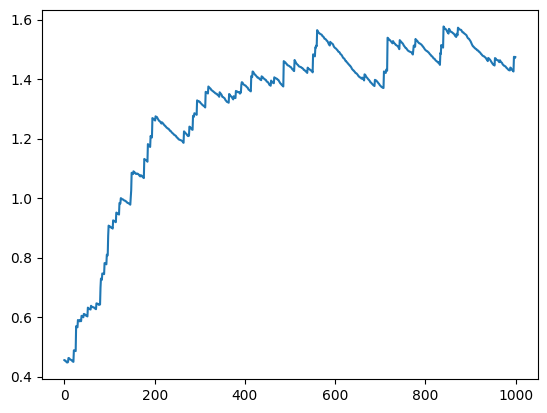

In [2]:
import numpy as np
import matplotlib.pyplot as plt

qtracker = StreamingQuantile(q=0.98, eta=0.001)
q = [qtracker(np.random.randn(1)) for _ in range(1000)]

plt.plot(q)
plt.show()


In [3]:
# Minimal Greenwald–Khanna (GK) ε-quantile sketch
# Deterministic, streaming, O((1/ε) log(εN)) space, O(1) amortized update.

from bisect import bisect_left
from math import floor

class GKQuantiles:
    def __init__(self, eps: float = 1e-2):
        assert 0 < eps < 1
        self.eps = eps
        self.n = 0
        self.S = []  # list of (v, g, Δ), ordered by v

    def insert(self, x: float):
        self.n += 1
        if not self.S:
            # first tuple
            self.S.append((x, 1, 0))
            return

        # find insertion index by value
        i = bisect_left([v for (v, _, _) in self.S], x)
        if i == 0:
            # smallest
            self.S.insert(0, (x, 1, 0))
        elif i == len(self.S):
            # largest
            self.S.append((x, 1, 0))
        else:
            # middle: GK sets Δ = floor(2εn) - 1
            v_i, g_i, d_i = self.S[i]
            delta = floor(2 * self.eps * self.n) - 1
            self.S.insert(i, (x, 1, max(delta, 0)))

        # compress occasionally
        if self.n % max(1, int(1 / (2 * self.eps))) == 0:
            self._compress()

    def _compress(self):
        # merge adjacent tuples when it preserves rank error
        S2 = [self.S[0]]
        for j in range(1, len(self.S)):
            v, g, d = self.S[j]
            v_prev, g_prev, d_prev = S2[-1]
            if g_prev + g + d <= floor(2 * self.eps * self.n):
                # merge j into previous
                S2[-1] = (v, g_prev + g, d_prev)
            else:
                S2.append((v, g, d))
        self.S = S2

    def query(self, q: float) -> float:
        """Return approximate q-quantile with rank error ≤ eps*n."""
        assert 0.0 <= q <= 1.0 and self.S
        r = 0
        rank_target = q * self.n
        tol = self.eps * self.n
        # scan until we bracket target rank within tolerance
        for i, (v, g, d) in enumerate(self.S):
            r_next = r + g
            # allowable max rank for this tuple:
            r_max = r_next + d
            if r_max >= rank_target - tol:
                return v
            r = r_next
        return self.S[-1][0]  # fallback: max value


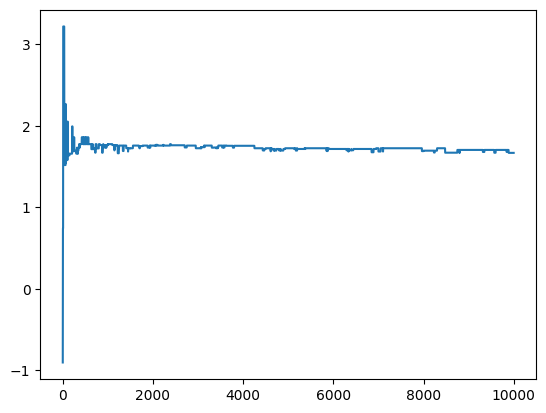

In [10]:
qtracker = GKQuantiles()
q = []
for _ in range(10000):
    qtracker.insert(np.random.randn(1))
    q.append(qtracker.query(0.98))

plt.plot(q)
plt.show()

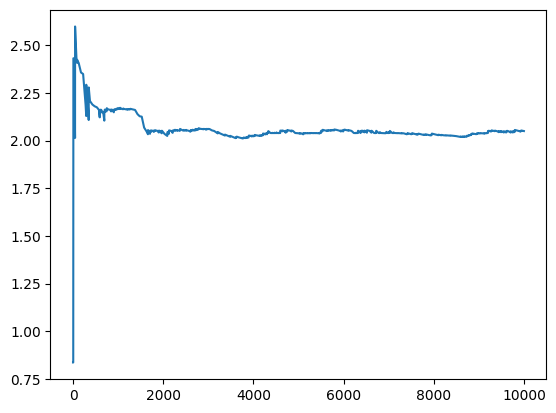

In [9]:
from tdigest import TDigest
import numpy as np
import matplotlib.pyplot as plt

td = TDigest()

q = []
for _ in range(10000):
    td.update(float(np.random.randn()))
    q.append(td.percentile(98))

plt.plot(q)
plt.show()



# final

In [ ]:
from bisect import bisect_left
from math import floor
from typing import List, Tuple

# ---- Minimal GK quantile sketch ----
class GKQuantiles:
    def __init__(self, eps: float = 1e-2):
        if not (0 < eps < 1):
            raise ValueError("eps must be in (0,1)")
        self.eps = eps
        self.n = 0  # total count
        self.S: List[Tuple[float, int, int]] = []  # (value, g, Δ), sorted by value

    def insert(self, x: float) -> None:
        x = float(x)
        self.n += 1
        if not self.S:
            self.S.append((x, 1, 0))
            return

        i = bisect_left([v for (v, _, _) in self.S], x)
        if i == 0:
            self.S.insert(0, (x, 1, 0))
        elif i == len(self.S):
            self.S.append((x, 1, 0))
        else:
            delta = floor(2 * self.eps * self.n) - 1
            if delta < 0: delta = 0
            self.S.insert(i, (x, 1, delta))

        # occasional compress keeps size small
        if self.n % max(1, int(1 / (2 * self.eps))) == 0:
            self._compress()

    def _compress(self) -> None:
        if not self.S: return
        S2 = [self.S[0]]
        for j in range(1, len(self.S)):
            v, g, d = self.S[j]
            v_prev, g_prev, d_prev = S2[-1]
            if g_prev + g + d <= floor(2 * self.eps * self.n):
                S2[-1] = (v, g_prev + g, d_prev)
            else:
                S2.append((v, g, d))
        self.S = S2

    def query(self, q: float) -> float:
        if not (0.0 <= q <= 1.0):
            raise ValueError("q must be in [0,1]")
        if not self.S:
            raise ValueError("empty sketch")

        r = 0
        rank_target = q * self.n
        tol = self.eps * self.n
        for (v, g, d) in self.S:
            r_next = r + g
            r_max = r_next + d
            if r_max >= rank_target - tol:
                return v
            r = r_next
        return self.S[-1][0]


# ---- Two-buffer, flip-every-window_step wrapper ----
class WindowQuantiles:
    """
    Two GK buffers, flip 'active' every `window_step`.
    - insert(x): goes to active buffer only
    - query(q): read from the non-active (holdover) buffer if it has data,
                otherwise fall back to active.
    This gives a cutoff based on ~last [window_step, 2*window_step) samples.
    """
    def __init__(self, eps: float = 1e-2, window_step: int = 5_000):
        if window_step <= 0:
            raise ValueError("window_step must be > 0")
        self.window_step = int(window_step)
        self.buffers = [GKQuantiles(eps), GKQuantiles(eps)]
        self.active = 0
        self.count_since_flip = 0

    def insert(self, x: float) -> None:
        # rotate if current window is full
        if self.count_since_flip >= self.window_step:
            self.active = 1 - self.active           # flip active
            self.buffers[self.active] = GKQuantiles(self.buffers[self.active].eps)  # clear new active
            self.count_since_flip = 0

        # add to active
        self.buffers[self.active].insert(x)
        self.count_since_flip += 1

    def query(self, q: float = 0.98) -> float:
        hold = 1 - self.active
        if self.buffers[hold].n > 0:
            return self.buffers[hold].query(q)
        # early phase: use whatever we have
        if self.buffers[self.active].n > 0:
            return self.buffers[self.active].query(q)
        raise ValueError("no data yet")


/var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/ipykernel_97190/3116255888.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)


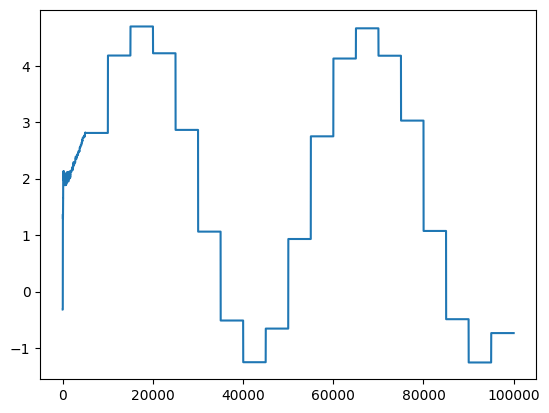

In [ ]:
qtracker = WindowQuantiles()
q = []
for i in range(100_000):
    qtracker.insert(np.random.randn(1) + 3*np.sin(i/8000))
    q.append(qtracker.query(0.98))

plt.plot(q)
plt.show()